# Analyze Region 3 - Arctic Canada North

This notebook analyzes the largest glaciers, ice caps, and ice fields in Region 3 - Arctic Canada North.

This region was deemed as needing a glacier complex analysis (ice caps and icefields), so note that the abbreviation "ic" stands for ice catchment aka glacier complex.

In [1]:
import os
import os.path as op
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio as rio
from rasterio.plot import plotting_extent
from earthpy import clip as cl
import earthpy.plot as ep

# set working dir
HOME = op.join(op.expanduser("~"))
os.chdir(os.path.join(HOME, "git/wgms-glacier-project"))

# Set up path to load scripts
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import scripts.wgms_scripts as ws

# Set Up Region Info

In [2]:
# Set region number, region name, and region index
# Once these are set, this notebook should run automatically for the specified region
region_number = "3"
region_name = "Arctic Canada North"

# The variable primeclass needs to be updated with the primary class of the ice complexes for the region
# This may need to be a list in some instances
# 2: icefield, 3: ice cap, 4: outlet glacier, 5: valley glacier, 6: mountain glacier
primeclass = 4 # For the largest glacier, this was set in the GLIMS database, I used it for the 2nd and 3rd largest as well

# Note for the region index, region_index_1 should be one less than the region number and 
# region_index_2 should be equal to the region number. For example, for region 1, index_1 should be set to 0 and 
# index_2 should be set to 1, etc.
region_index_1 = 2
region_index_2 = 3

# Ice cap/icefield epsg code used for calculating area
ic_epsg = '3347'

# This variable sets a value to determine whether the differences between the GLIMS and RGI glacier have been checked.
# When first starting a new notebook set handled to 0
# Once the differences have been checked and handled, set to 1 to pass the check
handled = 1

# * * * * * * * * Show Region Outline * * * * * * * *

In [3]:
# Open natural earth basemap TIF file
ne_fp = 'data/natural-earth/NE1_HR_LC_SR_W/NE1_HR_LC_SR_W.tif' # 10 m res
with rio.open(ne_fp) as ne_src:
    # Convert / read the data into a numpy array:
    ne_raster = ne_src.read()
    ne_src_extent = plotting_extent(ne_src)
    bounds = ne_src.bounds
    ne_raster_meta = ne_src.meta

In [4]:
# Open glacier regions
glacier_regions_fp = "data/gtn-g-glacier-regions/cleaned/GTN-G_glacier_regions_201707_cleaned.shp"
glacier_regions = gpd.read_file(glacier_regions_fp)

# Extract Region outline
region_outline = glacier_regions[region_index_1:region_index_2]

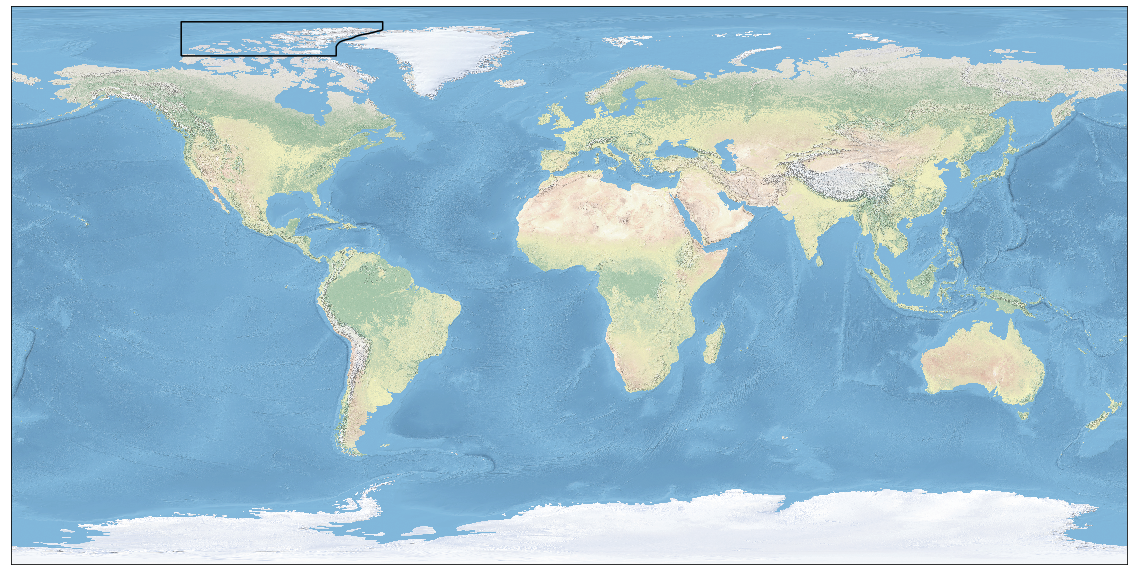

In [5]:
# Plot region outline over the natural earth
# Plot natural earth basemap
fig, ax = plt.subplots(figsize=(20, 20))

# Plot natural earth
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot region outline
region_outline.boundary.plot(ax=ax, color="black")

plt.show()

In [6]:
region_outline.bounds

,minx,miny,maxx,maxy
2,-125.0,74.0,-60.0,85.0


# * * * * * * * * Glacier Analysis * * * * * * * *

## Open GLIMS 3 Largest Glaciers Data

In [7]:
# Open GLIMS three largest glacier outlines for this region.
glims_glaciers_fn = "data/glims/processed/largest/glims_region_" + region_number + "_largest.shp"
glims_glaciers_df = gpd.read_file(glims_glaciers_fn)

In [8]:
# Check if GLIMS glacier names are of the "NoneType" because can't print legends and such if they are
# If they are, set them to a string "NONE"
glims_df_len = len(glims_glaciers_df)
for x in range(glims_df_len):
    if glims_glaciers_df['glac_name'][x] == None:
        print("GLIMS glacier " + str(x) + " equals none")
        glims_glaciers_df.loc[x, 'glac_name'] = 'NONE'

In [9]:
glims_glaciers_df

,region_no,glac_id,area,db_area,width,length,primeclass,min_elev,mean_elev,max_elev,src_date,glac_name,geometry
0,3,G280449E77998N,3263.95,3266.43,0.0,0.0,4.0,0.0,0.0,0.0,1999-07-09T00:00:00,None,"POLYGON Z ((-78.219859 77.972622 0, -78.224275..."
1,3,G278488E75058N,2622.81,2622.81,0.0,0.0,0.0,0.0,0.0,0.0,1999-06-15T00:00:00,None,"POLYGON Z ((-81.502932 75.316999 0, -81.481840..."
2,3,G276805E75127N,2170.55,2170.55,0.0,0.0,0.0,0.0,0.0,0.0,1999-06-15T00:00:00,None,"POLYGON Z ((-82.555437 75.34082100000001 0, -8..."
3,3,G280783E77677N,1890.61,1891.12,0.0,0.0,2.0,0.0,0.0,0.0,1999-07-09T00:00:00,None,"(POLYGON Z ((-78.219373 77.747365 0, -78.20402..."
4,3,G274800E74935N,1780.45,1780.65,0.0,0.0,0.0,0.0,0.0,0.0,1999-06-15T00:00:00,None,"POLYGON Z ((-86.136059 74.790851 0, -86.137223..."


## Open RGI 3 Largest Glaciers Data

In [10]:
# Open RGI three largest glacier outlines for this region.
rgi_glaciers_fn = "data/rgi/processed/largest/rgi_region_" + region_number + "_largest.shp"
rgi_glaciers_df = gpd.read_file(rgi_glaciers_fn)

In [11]:
# Check if RGI glacier names are of the "NoneType" because can't print legends and such if they are
# If they are, set them to a string "NONE"
rgi_df_len = len(rgi_glaciers_df)
for x in range(rgi_df_len):
    if rgi_glaciers_df['Name'][x] == None:
        print("RGI glacier " + str(x) + " equals none")
        rgi_glaciers_df.loc[x, 'Name'] = 'NONE'

RGI glacier 2 equals none
RGI glacier 4 equals none


In [12]:
rgi_glaciers_df

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
0,RGI60-03.01710,G280449E77998N,19999999,20039999,-79.5510,77.9980,3,4,3085.113,0,...,102,81426,0,0,0,1,3,9,Wykeham Glacier South,POLYGON ((-79.53182996399994 78.42253806900004...
1,RGI60-03.02467,G278488E75058N,19999999,20009999,-81.5122,75.0577,3,6,2622.813,0,...,128,82582,0,0,1,1,1,9,Devon Ice Cap Southeast2 Glacier,POLYGON ((-81.50293176099996 75.31699918000004...
2,RGI60-03.02489,G276805E75127N,19999999,20009999,-83.1946,75.1273,3,6,2170.549,1,...,212,70518,0,0,1,1,0,9,NONE,POLYGON ((-82.55543658499994 75.34082067100007...
3,RGI60-03.01678,G280783E77677N,19999999,20039999,-79.2170,77.6770,3,4,1892.023,0,...,108,85129,0,0,0,1,3,9,Easter Island South,POLYGON ((-79.55158695499995 77.81187922500004...
4,RGI60-03.01466,G274800E74935N,19999999,20009999,-85.1996,74.9351,3,6,1780.453,234,...,276,17684,0,0,0,0,0,9,NONE,POLYGON ((-86.13605894499995 74.79085143200007...


## Plot GLIMS Glaciers

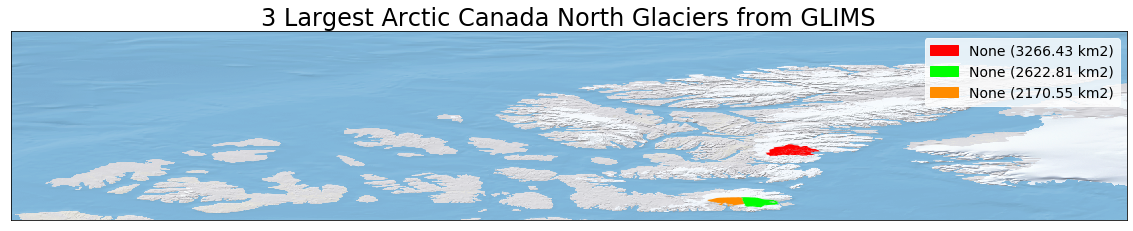

In [13]:
# Plot 3 largest glaciers on natural earth from GLIMS
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [glims_glaciers_df['glac_name'][0] + ' (' + str(glims_glaciers_df['db_area'][0]) + ' km2)',
                 glims_glaciers_df['glac_name'][1] + ' (' + str(glims_glaciers_df['db_area'][1]) + ' km2)',
                 glims_glaciers_df['glac_name'][2] + ' (' + str(glims_glaciers_df['db_area'][2]) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
glims_glaciers_df.iloc[0:1].plot(ax=ax, color='red')
glims_glaciers_df.iloc[1:2].plot(ax=ax, color='lime')
glims_glaciers_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers from GLIMS', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

## Plot RGI Glaciers

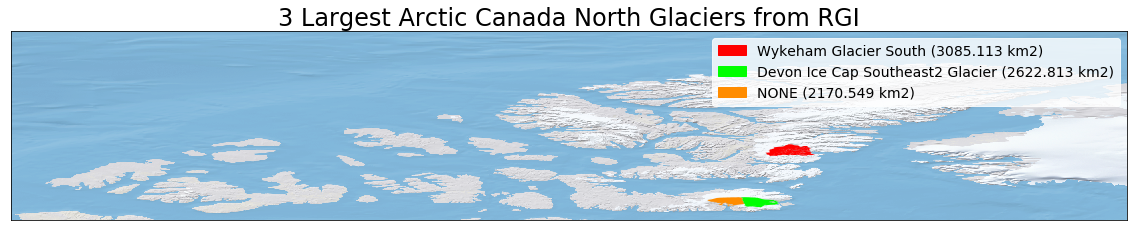

In [14]:
# Plot 3 largest glaciers on natural earth from RGI
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [rgi_glaciers_df['Name'][0] + ' (' + str(rgi_glaciers_df['Area'][0]) + ' km2)',
                 rgi_glaciers_df['Name'][1] + ' (' + str(rgi_glaciers_df['Area'][1]) + ' km2)',
                 rgi_glaciers_df['Name'][2] + ' (' + str(rgi_glaciers_df['Area'][2]) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from rgi dataframe
rgi_glaciers_df.iloc[0:1].plot(ax=ax, color='red')
rgi_glaciers_df.iloc[1:2].plot(ax=ax, color='lime')
rgi_glaciers_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers from RGI', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

## Compare Glaciers from GLIMS and RGI
Do they match? If yes, continue, if no, stop notebook and investigate. Once the differences have been investigated and corrected in the code below this code block, set handled to 1 in the "Set Up Region Info" section at the top of the notebook, so that it passes this test.

In [15]:
if (glims_glaciers_df['glac_name'][0] == rgi_glaciers_df['Name'][0] and 
    glims_glaciers_df['glac_name'][1] == rgi_glaciers_df['Name'][1] and 
    glims_glaciers_df['glac_name'][2] == rgi_glaciers_df['Name'][2]):
    print("They match!")
else:
    if handled != 1:
        # If this hasn't been handled, stop execution
        class StopExecution(Exception):
            def _render_traceback_(self):
                pass

        print("They do NOT Match! Stopping notebook.")
        raise StopExecution
    else:
        # If this has been handled, continue execution
        print("They do not match but this has been handled in the code below this section, so continue.")

They do not match but this has been handled in the code below this section, so continue.


## Create Final Glacier Shapefiles
This section creates and formats the final glacier dataframe, plots it to make sure it looks ok, and saves it to a shapefile.

### Create final glacier dataframe

In [16]:
# Set up the final dataframe that will be used when saving the final shapefiles
# Drop columns that are not needed for the final data (use GLIMS dataframe for this)
final_glacier_data_df = glims_glaciers_df.drop(['area', 'width', 'length', 'primeclass', 
                                                          'min_elev', 'mean_elev', 'max_elev'], axis=1)

# Add region_name column
final_glacier_data_df['reg_name'] = region_name

# Add primary class (primeclass) column. 
final_glacier_data_df['primeclass'] = primeclass

# Reorder the columns of the dataframe
final_glacier_data_df = final_glacier_data_df[['region_no', 'reg_name', 'glac_name', 'glac_id', 
                               'primeclass', 'db_area', 'src_date', 'geometry']]

# Rename some columns
final_glacier_data_df.rename(columns={'glac_id': 'glims_id', 'db_area': 'area_km2', 
                                       'src_date': 'date'}, inplace=True)

# Drop last 2 rows because they are the fourth and fifthe largest glaciers and we aren't interested in them
final_glacier_data_df.drop([3, 4], inplace = True)

In [17]:
# Calculate area and update dataframe as neccessary and clean the date format in the date column
# If GLIMS and RGI dates are the same year, then average the two areas.
# If GLIMS date is more recent, then use that average.
# If RGI date is more recent, then use that average. (Note I don't think this ever happens)
# Note only comparing by year because sometimes the month and day are not known. Year matching is close enough.
for x in range(3):
    # Exract and clean GLIMS date so that it is comparable to RGI date
    glims_date = glims_glaciers_df['src_date'][x][0:10].replace('-', '')
    glims_year = glims_date[0:4]
    print('glims date: ' + glims_date)
    #print('glims year: ' + glims_year)
    
    # Extract RGI date
    rgi_date = rgi_glaciers_df['BgnDate'][x]
    rgi_year = rgi_date[0:4]
    print('rgi date: ' + rgi_date)
    #print('rgi year: ' + rgi_year)
    
    if glims_year == rgi_year:
        # Average GLIMS and RGI areas
        area = np.average([glims_glaciers_df['db_area'][x], rgi_glaciers_df['Area'][x]])
        print('Averaging area: ' + str(area))
    elif glims_year > rgi_year:
        # Use GLIMS area for the area
        area = glims_glaciers_df['db_area'][x]
        print('Using GLIMS area: ' + str(area))
    elif rgi_year > glims_year:
        # Use RGI area for the area
        area = rgi_glaciers_df['Area'][x]
        print('Using RGI area: ' + str(area))
    else:
        print("Error. Area could not be calculated.")
    
    print('')
    # Set the area in the final dataframe
    final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('area_km2')] = area
    
    # Clean the date format in the final dataframe
    final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('date')] = glims_glaciers_df['src_date'][x][0:10]
    
    # Use the glacier names from RGI for the final data df
    if x == 0:
        # Simply set the final df name to the rgi name
        final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('glac_name')] = rgi_glaciers_df['Name'][x]
    if x == 1:
        # Clean up the Devon Ice Cap Southeast glacier name
        final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('glac_name')] = \
        rgi_glaciers_df['Name'][x].replace("2", " 2")
    if x == 2:
        # Set this name to Crocker Bay Glacier per Wyatt and Sharp(2015)
        final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('glac_name')] = 'Croker Bay Glacier'

glims date: 19990709
rgi date: 19999999
Averaging area: 3175.7715

glims date: 19990615
rgi date: 19999999
Averaging area: 2622.8115

glims date: 19990615
rgi date: 19999999
Averaging area: 2170.5495



In [18]:
final_glacier_data_df

,region_no,reg_name,glac_name,glims_id,primeclass,area_km2,date,geometry
0,3,Arctic Canada North,Wykeham Glacier South,G280449E77998N,4,3175.7715,1999-07-09,"POLYGON Z ((-78.219859 77.972622 0, -78.224275..."
1,3,Arctic Canada North,Devon Ice Cap Southeast 2 Glacier,G278488E75058N,4,2622.8115,1999-06-15,"POLYGON Z ((-81.502932 75.316999 0, -81.481840..."
2,3,Arctic Canada North,Croker Bay Glacier,G276805E75127N,4,2170.5495,1999-06-15,"POLYGON Z ((-82.555437 75.34082100000001 0, -8..."


### Plot final glacier dataframe to check accuracy

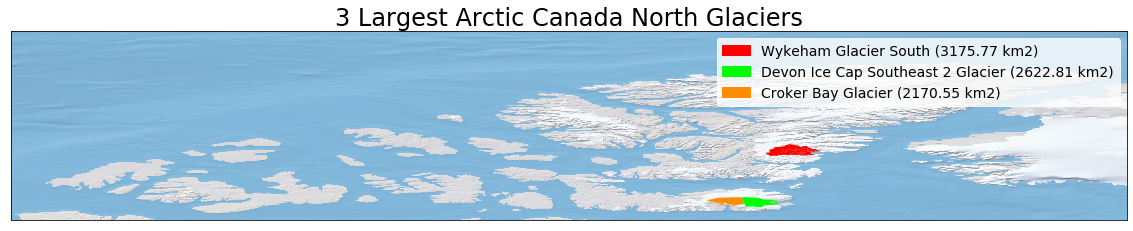

In [19]:
# Check that the geodataframe wasn't corrupted from these changes by plotting the data
# Plot 3 largest glaciers on natural earth from GLIMS
# Set up legend. Note that the sizes come from an average of GLIMS and RGI. 
# See wgms-glacier-project/data/comparison/compare-glims-rgi.xlsx
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [final_glacier_data_df['glac_name'][0] + \
                 ' (' + str(round(final_glacier_data_df['area_km2'][0], 2)) + ' km2)',
                 final_glacier_data_df['glac_name'][1] + \
                 ' (' + str(round(final_glacier_data_df['area_km2'][1], 2)) + ' km2)',
                 final_glacier_data_df['glac_name'][2] + \
                 ' (' + str(round(final_glacier_data_df['area_km2'][2], 2)) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
final_glacier_data_df.iloc[0:1].plot(ax=ax, color='red')
final_glacier_data_df.iloc[1:2].plot(ax=ax, color='lime')
final_glacier_data_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

### Create largest glacier shapefile from the final glacier dataframe

In [20]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
glacier_zipfile_fn = "data/final-dataset/region-" + region_number + "-largest-glaciers.zip"
if os.path.exists(glacier_zipfile_fn) == False:
    # Create the shapefile
    final_glacier_data_fn = "data/final-dataset/region-" + region_number + "-largest-glaciers.shp"
    final_glacier_data_df.to_file(driver='ESRI Shapefile', filename=final_glacier_data_fn)
    
    # Zip up the shapefile
    glacier_zipfile_fn = ws.zipshp(final_glacier_data_fn, Delete=True)
    print("Creating zipfile: " + glacier_zipfile_fn)
else:
    print(glacier_zipfile_fn + " already extists")

data/final-dataset/region-3-largest-glaciers.zip already extists


# * * * * * * * * Ice Cap Analysis * * * * * * * *

In [21]:
# Open this regions ice caps from the exploded version
ice_caps_ex_fn = "data/glims/processed/ice-caps/largest/largest-ice-caps-region_" + \
                  region_number + "_epsg" + ic_epsg + ".shp"
ice_caps_ex_df = gpd.read_file(ice_caps_ex_fn)

In [22]:
ice_caps_ex_df

,id,area,geometry
0,13,21159.547290,"POLYGON ((-80.798525 81.250319, -80.793099 81...."
1,9,19311.322286,"POLYGON ((-80.374956 77.30712200000001, -80.37..."
2,15,18917.749968,"POLYGON ((-74.264652 79.611407, -74.2605049999..."
3,1,13655.168957,POLYGON ((-81.72486000000001 74.56395999999999...
4,8,8142.302043,POLYGON ((-88.52648499999999 78.96548900000001...
5,2,5296.297354,"POLYGON ((-80.81959999999999 76.21677, -80.824..."
6,937,2824.569443,"POLYGON ((-91.178678 78.33252, -91.18216099999..."
7,444,2628.430841,"POLYGON ((-85.331221 76.470753, -85.33386 76.4..."
8,7,1871.517710,"POLYGON ((-79.291584 79.236374, -79.282926 79...."
9,1690,1769.351275,"POLYGON ((-84.797616 80.837233, -84.800308 80...."


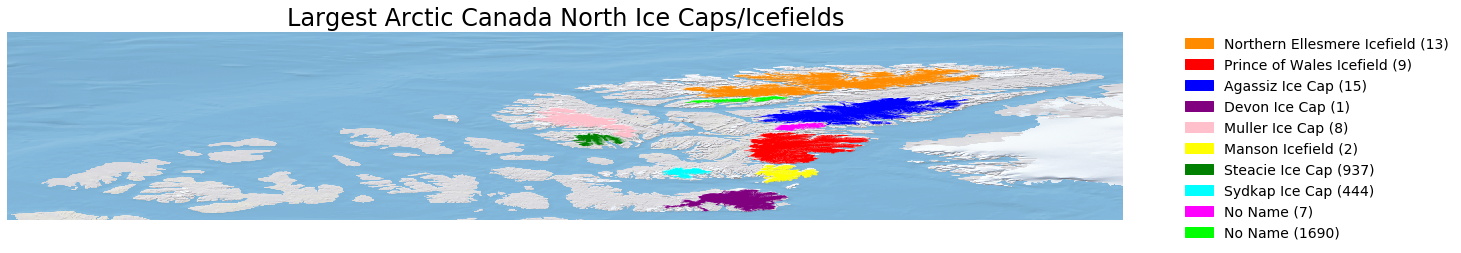

In [23]:
# Plot this regions ice caps in one frame
# Set up legend
legend_colors = ['darkorange', 'red', 'blue', 'purple', 'pink', 'yellow', 'green', 'cyan', 'magenta', 'lime']
legend_labels = ['Northern Ellesmere Icefield (13)', 'Prince of Wales Icefield (9)', 'Agassiz Ice Cap (15)', 
                 'Devon Ice Cap (1)', 'Muller Ice Cap (8)', 'Manson Icefield (2)', 'Steacie Ice Cap (937)', 
                 'Sydkap Ice Cap (444)', 'No Name (7)', 'No Name (1690)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
ice_caps_ex_df.iloc[0:1].plot(ax=ax, color="darkorange")
ice_caps_ex_df.iloc[1:2].plot(ax=ax, color="red")
ice_caps_ex_df.iloc[2:3].plot(ax=ax, color="blue")
ice_caps_ex_df.iloc[3:4].plot(ax=ax, color="purple")
ice_caps_ex_df.iloc[4:5].plot(ax=ax, color="pink")
ice_caps_ex_df.iloc[5:6].plot(ax=ax, color="yellow")
ice_caps_ex_df.iloc[6:7].plot(ax=ax, color="green")
ice_caps_ex_df.iloc[7:8].plot(ax=ax, color="cyan")
ice_caps_ex_df.iloc[8:9].plot(ax=ax, color="magenta")
ice_caps_ex_df.iloc[9:10].plot(ax=ax, color="lime")
ax.set_title('Largest ' + region_name + ' Ice Caps/Icefields', fontsize=24)
ax.set_axis_off()

# Add legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

## Create Final Ice Catchment Data Frame
This ice catchment data frame will then be saved to a shapefile.

In [24]:
# Update and reorganize ice_caps_ex_df to create final df
# Drop uneeded columns
final_catchment_data_df = ice_caps_ex_df.drop(['id'], axis=1)

# Drop last 4 rows because only interested in the top 3 ice caps and icefields
final_catchment_data_df.drop([6, 7, 8, 9], inplace = True)

# Add region_no column
final_catchment_data_df['region_no'] = region_number

# Add region_name column
final_catchment_data_df['reg_name'] = region_name

# Add primary class (primeclass) column. 
final_catchment_data_df['primeclass'] = [2, 2, 3, 3, 3, 2]

# Add catchment names
final_catchment_data_df['ic_name'] = ['Northern Ellesmere Icefield', 'Prince of Wales Icefield', 'Agassiz Ice Cap', 
                                      'Devon Ice Cap', 'Müller Ice Cap', 'Manson Icefield']

### Get ice catchment measurement dates from a range of glacier outline dates.

In [25]:
# Open GLIMS shapefile with all of the glacier outlines
glims_all_glaciers_fn = "data/glims/processed/cleaned/glims_region_" + region_number + "_cleaned.shp"
glims_all_glaciers_df = gpd.read_file(glims_all_glaciers_fn)

In [29]:
# Get glaciers in the Northern Ellesmere Icefield
ellesmere_ic_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[0:1].reset_index(drop=True))
ellesmere_glaciers = glims_all_glaciers_df.loc[ellesmere_ic_mask]

# Clean and print the minimum date and the maximum date
# glims_glaciers_df['src_date'][x][0:10]
ellesmere_glaciers_min_date = ellesmere_glaciers['src_date'].min()[0:10]
ellesmere_glaciers_max_date = ellesmere_glaciers['src_date'].max()[0:10]
print('ellesmere start date: ' + ellesmere_glaciers_min_date)
print('ellesmere end date: ' + ellesmere_glaciers_max_date)
print('')

# Get glaciers in the Prince of Wales Icefield
pow_ic_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[1:2].reset_index(drop=True))
pow_glaciers = glims_all_glaciers_df.loc[pow_ic_mask]

# Clean and print the minimum date and the maximum date
pow_glaciers_min_date = pow_glaciers['src_date'].min()[0:10]
pow_glaciers_max_date = pow_glaciers['src_date'].max()[0:10]
print('prince of wales start date: ' + pow_glaciers_min_date)
print('prince of wales end date: ' + pow_glaciers_max_date)
print('')

# Get glaciers in the Agassiz Ice Cap
agassiz_ic_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[2:3].reset_index(drop=True))
agassiz_glaciers = glims_all_glaciers_df.loc[agassiz_ic_mask]

# Clean and print the minimum date and the maximum date
agassiz_glaciers_min_date = agassiz_glaciers['src_date'].min()[0:10]
agassiz_glaciers_max_date = agassiz_glaciers['src_date'].max()[0:10]
print('agassiz start date: ' + agassiz_glaciers_min_date)
print('agassiz end date: ' + agassiz_glaciers_max_date)
print('')

# Get glaciers in the Devon Ice Cap
devon_ic_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[3:4].reset_index(drop=True))
devon_glaciers = glims_all_glaciers_df.loc[devon_ic_mask]

# Clean and print the minimum date and the maximum date
devon_glaciers_min_date = devon_glaciers['src_date'].min()[0:10]
devon_glaciers_max_date = devon_glaciers['src_date'].max()[0:10]
print('devon start date: ' + devon_glaciers_min_date)
print('devon end date: ' + devon_glaciers_max_date)
print('')

# Get glaciers in the Muller Ice Cap
muller_ic_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[4:5].reset_index(drop=True))
muller_glaciers = glims_all_glaciers_df.loc[muller_ic_mask]

# Clean and print the minimum date and the maximum date
muller_glaciers_min_date = muller_glaciers['src_date'].min()[0:10]
muller_glaciers_max_date = muller_glaciers['src_date'].max()[0:10]
print('muller start date: ' + muller_glaciers_min_date)
print('muller end date: ' + muller_glaciers_max_date)
print('')

# Get glaciers in the Manson icefield
manson_ic_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[5:6].reset_index(drop=True))
manson_glaciers = glims_all_glaciers_df.loc[manson_ic_mask]

# Clean and print the minimum date and the maximum date
manson_glaciers_min_date = manson_glaciers['src_date'].min()[0:10]
manson_glaciers_max_date = manson_glaciers['src_date'].max()[0:10]
print('manson start date: ' + manson_glaciers_min_date)
print('manson end date: ' + manson_glaciers_max_date)

ellesmere start date: 1999-06-15
ellesmere end date: 1999-06-15

prince of wales start date: 1999-06-15
prince of wales end date: 1999-07-09

agassiz start date: 1999-06-15
agassiz end date: 1999-06-15

devon start date: 1999-06-15
devon end date: 1999-06-15

muller start date: 1999-06-15
muller end date: 1999-07-25

manson start date: 2002-07-19
manson end date: 2002-07-19


In [30]:
# Add the dates to the dataframe
final_catchment_data_df['min_date'] = [ellesmere_glaciers_min_date, pow_glaciers_min_date, agassiz_glaciers_min_date,
                                       devon_glaciers_min_date, muller_glaciers_min_date, manson_glaciers_min_date]

final_catchment_data_df['max_date'] = [ellesmere_glaciers_max_date, pow_glaciers_max_date, agassiz_glaciers_max_date,
                                       devon_glaciers_max_date, muller_glaciers_max_date, manson_glaciers_max_date]

# Reorder the columns
final_catchment_data_df = final_catchment_data_df[['region_no', 'reg_name', 'ic_name', 'primeclass', 'area', 'min_date', 
                                                   'max_date', 'geometry']]
# Rename the area column
final_catchment_data_df.rename(columns={'area': 'area_km2'}, inplace=True)
                                     
# Reset index
final_catchment_data_df = final_catchment_data_df.reset_index(drop=True)

In [31]:
final_catchment_data_df

,region_no,reg_name,ic_name,primeclass,area_km2,min_date,max_date,geometry
0,3,Arctic Canada North,Northern Ellesmere Icefield,2,21159.547290,1999-06-15,1999-06-15,"POLYGON ((-80.798525 81.250319, -80.793099 81...."
1,3,Arctic Canada North,Prince of Wales Icefield,2,19311.322286,1999-06-15,1999-07-09,"POLYGON ((-80.374956 77.30712200000001, -80.37..."
2,3,Arctic Canada North,Agassiz Ice Cap,3,18917.749968,1999-06-15,1999-06-15,"POLYGON ((-74.264652 79.611407, -74.2605049999..."
3,3,Arctic Canada North,Devon Ice Cap,3,13655.168957,1999-06-15,1999-06-15,POLYGON ((-81.72486000000001 74.56395999999999...
4,3,Arctic Canada North,Müller Ice Cap,3,8142.302043,1999-06-15,1999-07-25,POLYGON ((-88.52648499999999 78.96548900000001...
5,3,Arctic Canada North,Manson Icefield,2,5296.297354,2002-07-19,2002-07-19,"POLYGON ((-80.81959999999999 76.21677, -80.824..."


### Plot the final catchment dataframe to verify it looks correct

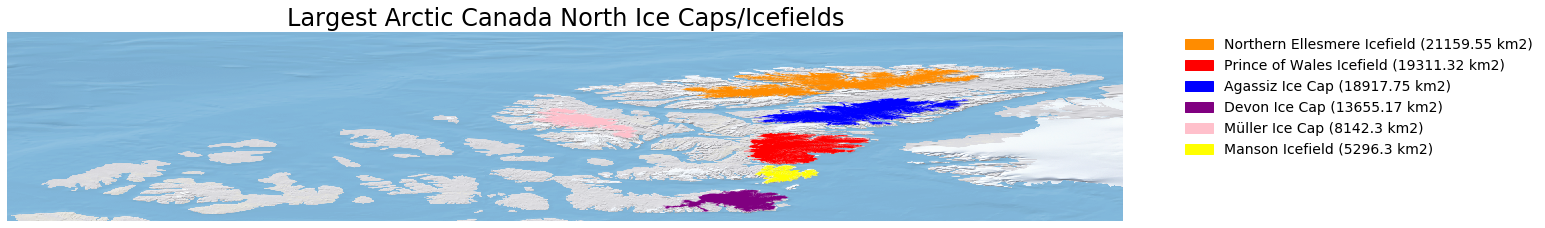

In [32]:
# Plot this regions ice caps in one frame
# Set up legend
legend_colors = ['darkorange', 'red', 'blue', 'purple', 'pink', 'yellow']
legend_labels = [final_catchment_data_df['ic_name'][0] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][0], 2)) + ' km2)', 
                 final_catchment_data_df['ic_name'][1] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][1], 2)) + ' km2)', 
                 final_catchment_data_df['ic_name'][2] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][2], 2)) + ' km2)', 
                 final_catchment_data_df['ic_name'][3] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][3], 2)) + ' km2)', 
                 final_catchment_data_df['ic_name'][4] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][4], 2)) + ' km2)', 
                 final_catchment_data_df['ic_name'][5] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][5], 2)) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
final_catchment_data_df.iloc[0:1].plot(ax=ax, color="darkorange")
final_catchment_data_df.iloc[1:2].plot(ax=ax, color="red")
final_catchment_data_df.iloc[2:3].plot(ax=ax, color="blue")
final_catchment_data_df.iloc[3:4].plot(ax=ax, color="purple")
final_catchment_data_df.iloc[4:5].plot(ax=ax, color="pink")
final_catchment_data_df.iloc[5:6].plot(ax=ax, color="yellow")
ax.set_title('Largest ' + region_name + ' Ice Caps/Icefields', fontsize=24)
ax.set_axis_off()

# Add legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

### Save final catchment dataframe to a shapefile

In [33]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
catchment_zipfile_fn = "data/final-dataset/region-" + region_number + "-largest-complexes.zip"
if os.path.exists(catchment_zipfile_fn) == False:
    # Create the shapefile
    final_catchment_data_fn = "data/final-dataset/region-" + region_number + "-largest-complexes.shp"
    final_catchment_data_df.to_file(driver='ESRI Shapefile', filename=final_catchment_data_fn)
    
    # Zip up the shapefile
    catchment_zipfile_fn = ws.zipshp(final_catchment_data_fn, Delete=True)
    print("Creating zipfile: " + catchment_zipfile_fn)
else:
    print(catchment_zipfile_fn + " already extists")

Creating zipfile: data/final-dataset\region-3-largest-complexes.zip
